In [1]:
import pandas as pd
import numpy as np
import os
import pyvis
import networkx as nx
from matplotlib import pyplot as plt
from itertools import product
import plotly.graph_objects as go
import plotly.express as px
# pip install --upgrade nbformat

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
current_directory = os.getcwd()

In [4]:
skus_data = pd.read_csv(f"{current_directory}/data/skus.csv", delimiter = ",")
transactions_data = pd.read_csv(f"{current_directory}/data/transactions.csv", delimiter = ",")

- **REVENUE = SALE_PRICE_EX_VAT * QTY**
- **SALE_PRICE_EX_VAT = NORMAL PRICE - DISCOUNT**

In [5]:
skus_data.columns

Index(['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY', 'SUBCATEGORY1',
       'SUBCATEGORY2', 'BRAND', 'ITEM_WEIGHT', 'ITEM_UNIT_OF_MEASURE'],
      dtype='object')

### Departments and categories analysis

In [18]:
# skus_data[skus_data["DEPARTMENT"] == "Misc."] ## Get rid of that

# skus_data[skus_data["DEPARTMENT"] == "Services"] ## To get rid of? This is dog only


# skus_data[skus_data["DEPARTMENT"] == "Weighed"] ## Distinguish per category: 'Bird', 'Dog', 'Pond', 'Wildbird'
## Dom.Bird and Wildbird can be regrouped as Bird

In [19]:
hierarchical_categories = skus_data[["DEPARTMENT", "CATEGORY"]].drop_duplicates()
# fig = px.sunburst(hierarchical_categories, path=["DEPARTMENT", "CATEGORY"], title="Sunburst Chart Example")
# fig.show()

In [ ]:
fig = px.treemap(hierarchical_categories, path=["DEPARTMENT", "CATEGORY"], title="Categories in departments")


### Other SKUs in transactions that are not part of the list of 500 best-selling items

In [10]:
result = {x for x in transactions_data["SKU"].unique() if x not in skus_data["SKU"].unique()}
result

set()

### Missing SKUs in transactions

In [6]:
result2 = {x for x in skus_data["SKU"].unique() if x not in transactions_data["SKU"].unique()}
skus_data[skus_data["SKU"].isin(result2)]

,SKU,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SUBCATEGORY1,SUBCATEGORY2,BRAND,ITEM_WEIGHT,ITEM_UNIT_OF_MEASURE
46,65813,Sizzlers Bacon Treat Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
47,65815,Bacon/Cheese Whirlers Maxi,Dog,Treat,Other,Other,Bakers,0.001,KG
123,51849,Miss Purfect Strip Teasers,Cat,Treat,Other,Na,Miss Purfect,0.050,KG
134,54646,Beef Meat Only Dinner,Dog,Food,Frozen,Adult,Durham Animal Feeds,0.500,KG
189,30365,Delivery,Misc.,Na,Na,Na,NaN,NaN,NaN
367,50806,Naturals Gig Mv Chkn,Cat,Food,S.S.Wet,Adult,Gourmet,0.810,KG
498,65495,Chicken Mince,Dog,Food,Frozen,Adult,Raw And Simple,1.500,KG


### Count number of unique items sold together per transaction
A purchase will be a unique transaction with possibly multiple items sold at the same time (i.e.: same unique transacation ID).
We want to know the distribution of number of items sold per purchase.

<BarContainer object of 12 artists>

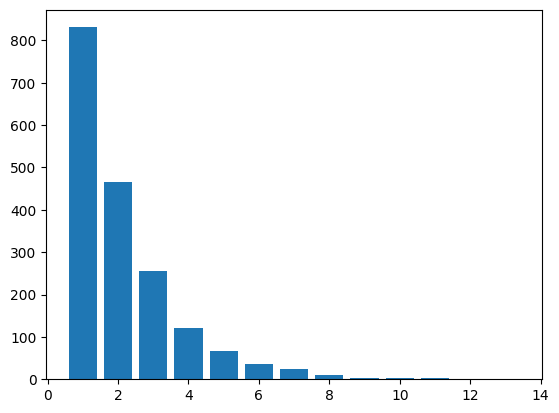

In [7]:
sku_transactions_data = transactions_data.groupby(["TRANSACTION_ID"]).agg({
    "SKU" : lambda x : x.nunique()
}).reset_index().value_counts("SKU")
plt.bar(sku_transactions_data.index, sku_transactions_data.values)

### Percentage of transactions with 2 items or more sold

In [8]:
round(1-sku_transactions_data.loc[1]/sku_transactions_data.sum(), 2)*100

np.float64(54.0)

### Number of times an item has been bought

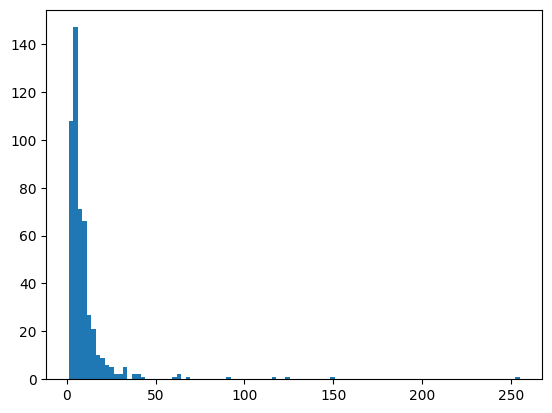

In [9]:
item_purchases = transactions_data.groupby(["SKU"]).agg(
    {"TRANSACTION_ID" : "count"}
).reset_index().rename(columns = {"TRANSACTION_ID" : "TOTAL_TRANSACTION"})

plt.hist(item_purchases["TOTAL_TRANSACTION"], bins = 100);

In [ ]:
transactions_data = transactions_data.merge(item_purchases, on = "SKU", how = "left")

# Low-frequence items analysis
What percentage of revenue do we lose by dropping low-frequency items?

**REVENUE = SALE_PRICE_EX_VAT * QTY**


In [149]:
transactions_data[transactions_data["TOTAL_TRANSACTION"] >= 6]["REVENUE"].sum()/transactions_data["REVENUE"].sum()

np.float64(0.7951121178296454)

### Check if a transaction ID is unique or unique per store

In [12]:
transactions_data.groupby("TRANSACTION_ID").agg({
    "STORE_ID" : lambda x : x.nunique()
    }
)["STORE_ID"].nunique()

1

Transaction ID is indeed unique across all the stores. It is not a unique Transaction ID per store.

### There are negative quantities. Is that returned items? We can drop them as it is only a few transactions.


In [13]:
transactions_data[transactions_data["QTY"]<0]

,TRANSACTION_ID,TRANSACTION_LINE_ID,STORE_ID,SKU,SALE_PRICE_EX_VAT,REVENUE,QTY,DISCOUNT,TOTAL_TRANSACTION
1017,126149042,446790067,15,36022,7.11700,-2.8468,-0.4,-0.1498,11
1100,126104768,446708690,13,62955,1.57500,-1.5750,-1.0,0.0000,27
1175,125741803,445667330,212,65597,0.00000,0.0000,-1.0,0.0000,150
3957,125608948,445270684,216,65597,0.00000,0.0000,-1.0,0.0000,150
4700,126028818,446433485,97,64952,1.04165,-2.0833,-2.0,0.0000,68
4870,125608948,445274062,216,65596,0.00000,0.0000,-1.0,0.0000,19


### Effect of promotion on data

Flag if there is a discount applied and calculate the value of the discount

In [296]:
transactions_data_discount = transactions_data.copy()

In [297]:
transactions_data_discount["DISCOUNT_APPLIED"] = transactions_data_discount["DISCOUNT"].map(lambda x : 0 if x==0 else 1)
transactions_data_discount["DISCOUNT_APPLIED"].value_counts()
transactions_data_discount["DISCOUNT_VALUE"] = 1-transactions_data_discount["SALE_PRICE_EX_VAT"]/(transactions_data_discount["SALE_PRICE_EX_VAT"] + transactions_data_discount["DISCOUNT"])

Flag SKUs with transactions with and without discount for further comparison

In [298]:
discount_df = transactions_data_discount.groupby(["SKU"]).agg(
        DISCOUNT_NO_DISCOUNT = ("DISCOUNT_APPLIED", lambda x : x.nunique())
).reset_index()

transactions_data_discount = transactions_data_discount.merge(discount_df, on = "SKU", how = "left")
transactions_data_discount["DISCOUNT_NO_DISCOUNT"].value_counts()

DISCOUNT_NO_DISCOUNT
2    3372
1    1517
Name: count, dtype: int64

Measure impact of discount on sales volume

In [311]:
def filter_skus_per_discount_value(df, threshold_discount):
    sku_discount = df[df["DISCOUNT_VALUE"]>=threshold_discount]["SKU"]
    df = df[(df["SKU"].isin(sku_discount))]
    return df[(df["DISCOUNT_VALUE"]>=threshold_discount) | (df["DISCOUNT_APPLIED"]==0)]

In [316]:
def measure_sales_volume_per_transaction(df):
        qty_df = df.groupby(["SKU", "DISCOUNT_APPLIED"]).agg(
                QTY_SOLD = ("QTY", "sum"),
                NBRE_TRANSACTIONS = ("QTY", "count")
        )
        qty_df["RATIO_QTY_SOLD"] = qty_df["QTY_SOLD"]/qty_df["NBRE_TRANSACTIONS"]
        qty_df = qty_df.reset_index()
        return qty_df[qty_df["DISCOUNT_APPLIED"]==0]["RATIO_QTY_SOLD"].mean(), qty_df[qty_df["DISCOUNT_APPLIED"]==1]["RATIO_QTY_SOLD"].mean()

In [337]:
all_threshold_discount = []
all_ratio_no_discount = []
all_ratio_discount = []
for threshold_discount in np.arange(0, 0.55, 0.05):
    transactions_data_discount_impact = transactions_data_discount.copy()
    transactions_data_discount_impact = transactions_data_discount_impact[transactions_data_discount_impact["DISCOUNT_NO_DISCOUNT"]==2]
    transactions_data_discount_filtered = filter_skus_per_discount_value(transactions_data_discount_impact, threshold_discount)
    ratio_without_discount, ratio_with_discount = measure_sales_volume_per_transaction(transactions_data_discount_filtered)

    all_threshold_discount.append(threshold_discount)
    all_ratio_no_discount.append(ratio_without_discount)
    all_ratio_discount.append(ratio_with_discount)

In [354]:
df_impact_discount = pd.DataFrame({"DISCOUNT_VALUE" : all_threshold_discount, "SALES_RATIO_NO_DISCOUNT" : all_ratio_no_discount, "SALES_RATIO_WITH_DISCOUNT" : all_ratio_discount})

In [364]:
df_impact_discount["RELATIVE_DIFFERENCE"] = abs(df_impact_discount["SALES_RATIO_WITH_DISCOUNT"] - df_impact_discount["SALES_RATIO_NO_DISCOUNT"])/df_impact_discount["SALES_RATIO_WITH_DISCOUNT"]

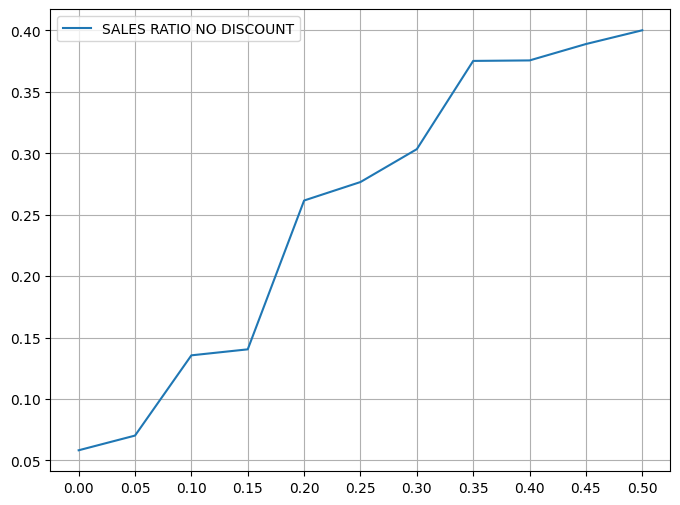

In [365]:
plt.figure(figsize = (8,6))
plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["RELATIVE_DIFFERENCE"], label = "SALES RATIO NO DISCOUNT")
plt.xticks(df_impact_discount["DISCOUNT_VALUE"])
plt.yticks()
plt.legend()
plt.grid()
plt.show()

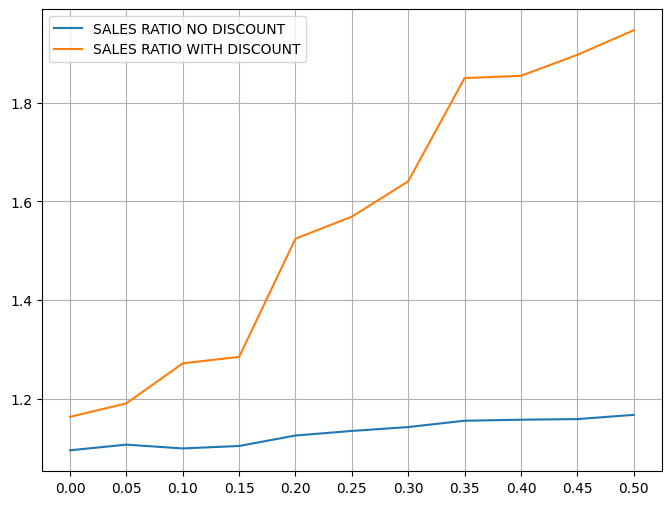

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["SALES_RATIO_NO_DISCOUNT"], label = "SALES RATIO NO DISCOUNT")
plt.plot(df_impact_discount["DISCOUNT_VALUE"], df_impact_discount["SALES_RATIO_WITH_DISCOUNT"], label = "SALES RATIO WITH DISCOUNT")
plt.xticks(df_impact_discount["DISCOUNT_VALUE"])
plt.yticks()
plt.legend()
plt.grid()
plt.show()